In [37]:
# Predicting Sequential Data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm


In [39]:
class WeatherDataset(Dataset):
    def __init__(self, dataset_file, day_range, split_date, train_test="train"):
        df = pd.read_csv(dataset_file)
        df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
        df.set_index('Date', inplace=True)

        # Calculate the mean and std to normalise the data
        mean = df.mean()
        std = df.std()
        df = (df - mean) / std

        self.mean = torch.tensor(mean.to_numpy()).reshape(1, -1)
        self.std = torch.tensor(std.to_numpy()).reshape(1, -1)

        # Split the dataset to test/train set based on a split date
        if train_test == "train":
            self.dataset = df[df.index < split_date]
        elif train_test == "test":
            self.dataset = df[df.index >= split_date]
        else:
            ValueError("train_test should be train or test")

        self.day_range = day_range

    def __getitem__(self, index):
        # Index a range of days
        end_index = index + self.day_range
        current_series = self.dataset.iloc[index:end_index]

        day_tensor = torch.LongTensor(current_series.index.day.to_numpy())
        month_tensor = torch.LongTensor(current_series.index.month.to_numpy())
        data_values = torch.FloatTensor(current_series.values)

        return day_tensor, month_tensor, data_values

    def __len__(self):
        return len(self.dataset) - self.day_range

In [40]:
# Dealing with Max Daily and Rainfall Dataset

# Define dataset file full path
dataset_file = "../datasets/weather.csv"

# Test-Train split on date
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 15

# Number of days the MLP will take in as input
days_in = 14

# Days in input seq must be larger than the MLP input size
assert day_range > days_in

# Define hyperparameters
learning_rate = 1e-4
nepochs = 64
batch_size = 8
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")


In [41]:
print("Number of training examples:", len(dataset_train))
print("Number of testing examples:", len(dataset_test))

Number of training examples: 3480
Number of testing examples: 412


In [42]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

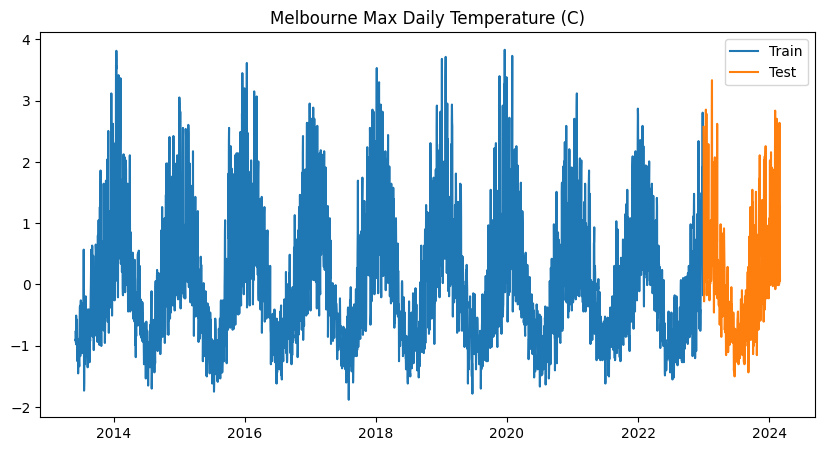

In [43]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(['Train', 'Test'])

In [44]:
# Define a res-mlp block
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size // 2)

        self.norm2 = nn.LayerNorm(input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, output_size)

        self.fc3 = nn.Linear(input_size, output_size)

        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.norm1(x))
        skip = self.fc3(x)

        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)

        return x + skip
    
class ResMLP(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1):
        super(ResMLP, self).__init__()

        seq_data_len = seq_len * 2

        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.LayerNorm(4 * seq_data_len),
            nn.Linear(4 * seq_data_len, 128)
        )

        blocks = [
            ResBlockMLP(128, 128) for _ in range(num_blocks)
        ]
        self.res_blocks = nn.Sequential(*blocks)

        self.fc_out = nn.Linear(128, output_size)
        self.act = nn.ELU()

    def forward(self, input_seq):
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        input_vec = self.input_mlp(input_seq)

        x = self.act(self.res_blocks(input_vec))

        return self.fc_out(x)

In [45]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

In [46]:
# Create the model
weather_mlp = ResMLP(seq_len=days_in, output_size=2).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(weather_mlp.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = nn.MSELoss()

In [47]:
# Let's see how many parameters our model has
num_model_params = 0
for param in weather_mlp.parameters():
    num_model_params += param.flatten().shape[0]

print(f"This model has {num_model_params} (Approximatly {num_model_params // 10e9} Million) Parameters")


This model has 51666 (Approximatly 0.0 Million) Parameters


In [48]:
training_loss_logger = []

In [49]:
# Iterate over the number of epochs
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_mlp.train()
    
    # Iterate over the training data loader
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        
        # Extract the initial sequence block to be used as input for the model
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize the loss for the current batch
        loss = 0
        
        # Iterate over the remaining sequence to predict the next day values
        for i in range(day_range - days_in):
            # Get the target sequence block for the next day
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Make predictions using the model
            data_pred = weather_mlp(seq_block)
            
            # Accumulate the loss for the current prediction
            loss += loss_fn(data_pred, target_seq_block)
            
            # Update the input sequence by removing the oldest date and adding the new prediction
            # Detach the new sequence to prevent backpropagation through the old sequence
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1).detach()

        # Average the accumulated loss over the number of steps
        loss /= i + 1
        
        # Zero the gradients before performing backpropagation
        optimizer.zero_grad()
        
        # Perform backpropagation to compute gradients
        loss.backward()
        
        # Update the model parameters using the optimizer
        optimizer.step()
        
        # Log the training loss for later analysis
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

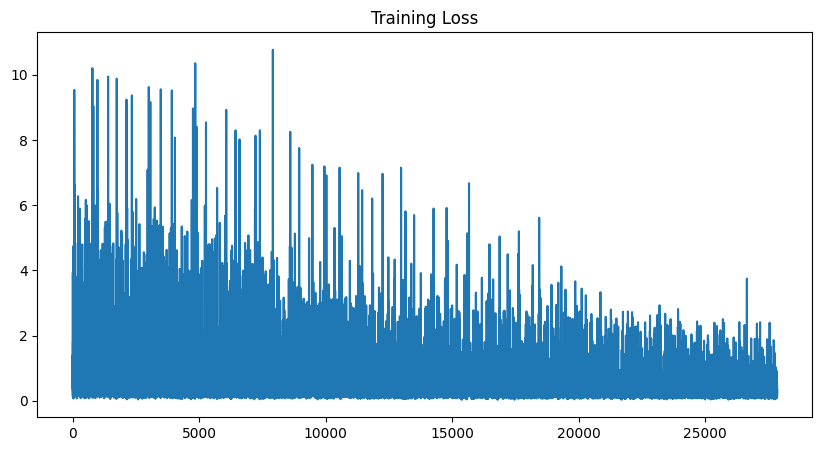

In [50]:
# Plot Train Loss
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [51]:
# Convert the test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize a list to log predictions
log_predictions = []

# Set the model to evaluation mode
weather_mlp.eval()

# Disable gradient calculation for the prediction process
with torch.no_grad():
    # Extract the initial sequence block to be used as input for the model
    # - unsqueeze(0) adds a batch dimension to the input
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)
    
    # Iterate over the sequence to predict the next day values
    for i in range(data_tensor.shape[0] - days_in):
        # Make predictions using the model
        data_pred = weather_mlp(seq_block)
        
        # Log the prediction
        log_predictions.append(data_pred.cpu())
        
        # Update the input sequence by removing the oldest date and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions using the dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

# Unnormalize the original data using the dataset's standard deviation and mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Trim the initial sequence from the unnormalized data to match the length of predictions
un_norm_data = un_norm_data[days_in:]


In [52]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 61.52


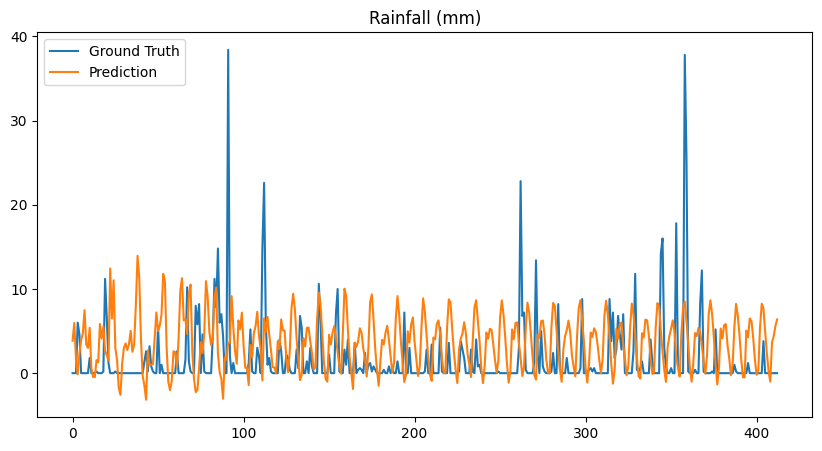

In [53]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

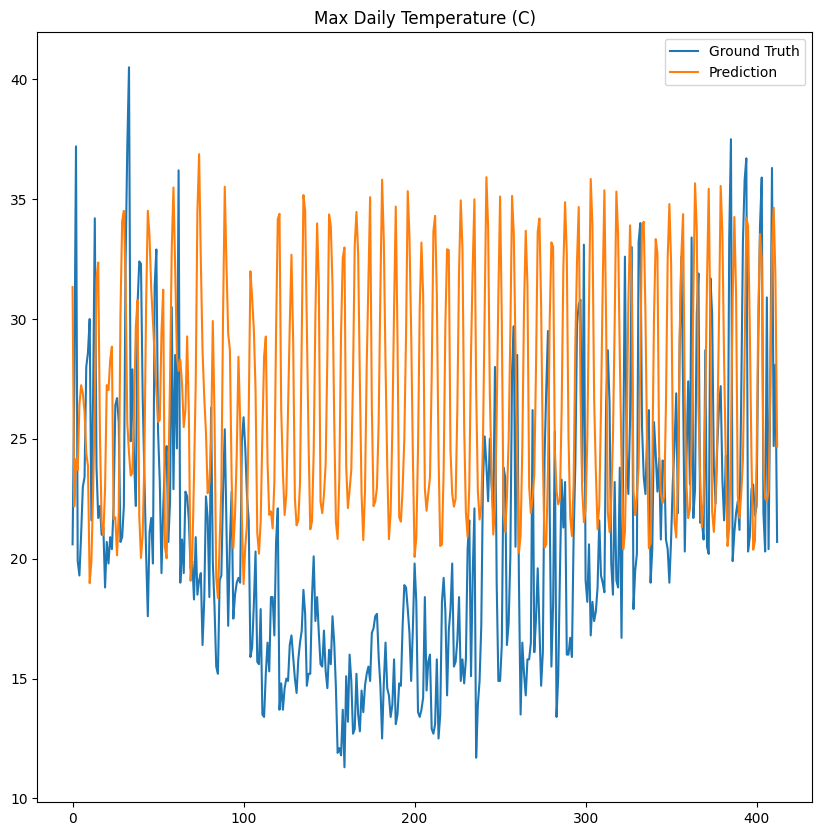

In [54]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])